In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import tensorflow as tf 
from tensorflow import keras 
from keras import optimizers 
from keras import regularizers 
import matplotlib.pyplot as plt 
from keras.models import Sequential 
from sklearn.metrics import confusion_matrix
from keras.utils.vis_utils import plot_model 
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import ModelCheckpoint,EarlyStopping 
from tensorflow.keras.optimizers import Adam, RMSprop, SGD 
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from tensorflow.keras.models import Model
!pip install livelossplot
from PIL import Image, ImageOps
import glob
import os 
import datetime 
from livelossplot.inputs.tf_keras import PlotLossesCallback 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive')

Mounted at /content/gdrive


In [3]:
train_dir = "/content/gdrive/MyDrive/singles_clean/big/"

DATA AUGMENTATION 

In [4]:
#Data Augmentation
def Data_aug(train_dir):

  batch_size=6  
  train_datagen = ImageDataGenerator(rescale = 1./255,
                                        rotation_range=40,
                                        width_shift_range=0.2,
                                        height_shift_range=0.2,
                                        shear_range=0.2,
                                        zoom_range=0.2,
                                        horizontal_flip=True,
                                        fill_mode='nearest',validation_split=0.2)



  train_generator = train_datagen.flow_from_directory(train_dir,
                                                      target_size=(224,224),
                                                      batch_size=batch_size,
                                                      class_mode='binary',
                                                      subset='training')

  valid_generator = train_datagen.flow_from_directory(train_dir,
                                                      target_size=(224,224),
                                                      batch_size=batch_size,
                                                      class_mode='binary',
                                                      subset='validation')
  return train_generator , valid_generator

In [5]:
data_train,data_validation=Data_aug(train_dir)

Found 189 images belonging to 2 classes.
Found 47 images belonging to 2 classes.


TRANSFER LEARNING WITH VGG NET

In [6]:
vgg_model = VGG16(include_top=False, input_shape=(224, 224, 3))

for layer in vgg_model.layers:
    layer.trainable=False

flat1 = Flatten()(vgg_model.layers[-1].output)
class1 = Dense(256, activation='relu')(flat1)
output = Dense(1, activation='sigmoid')(class1)

model = Model(inputs = vgg_model.inputs, outputs = output)


58889256/58889256 [==============================] - 0s 0us/step


MODEL TRAINING

In [7]:
#Model Training
def Model_Training(train_generator, valid_generator,model):
  opt=Adam(learning_rate=0.001)
  model.compile(loss = 'binary_crossentropy', optimizer = opt, metrics=['accuracy'])


  reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                patience=2, min_lr=0.0001, mode='auto')

  # Early_stopping=EarlyStopping(monitor="val_loss",mode="auto",restore_best_weights=True)

  checkpoint = ModelCheckpoint("Best_vgg_model_fruit.hdf5", monitor='val_accuracy',
                              save_weights_only=True, mode='max', verbose=1)

  callbacks = [PlotLossesCallback(), checkpoint, reduce_lr]

  history = model.fit(train_generator,
                      validation_data = valid_generator,
                      epochs=20, verbose=1, callbacks=callbacks)
  return history

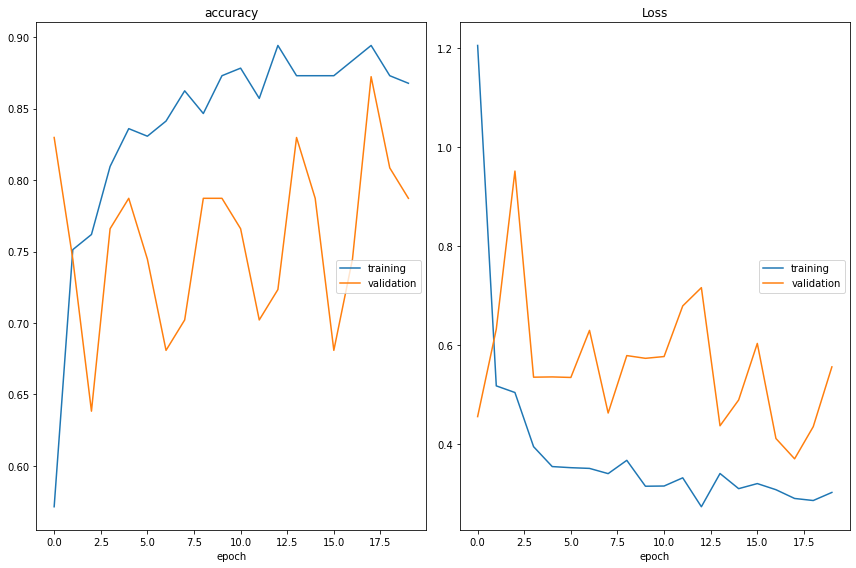

accuracy
	training         	 (min:    0.571, max:    0.894, cur:    0.868)
	validation       	 (min:    0.638, max:    0.872, cur:    0.787)
Loss
	training         	 (min:    0.273, max:    1.205, cur:    0.302)
	validation       	 (min:    0.369, max:    0.951, cur:    0.555)

Epoch 20: saving model to Best_vgg_model_fruit.hdf5
32/32 [==============================] - 4s 132ms/step - loss: 0.3015 - accuracy: 0.8677 - val_loss: 0.5552 - val_accuracy: 0.7872 - lr: 1.0000e-04


In [8]:
Best_model=Model_Training(data_train,data_validation, model)

In [9]:
model.save("vgg_model.h5")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
def evaluation_graph(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend(loc=0)
  plt.figure()

  accuracy_plot=plt.show()

  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend(loc=0)
  plt.figure()

  loss_plot=plt.show()
  return accuracy_plot, loss_plot

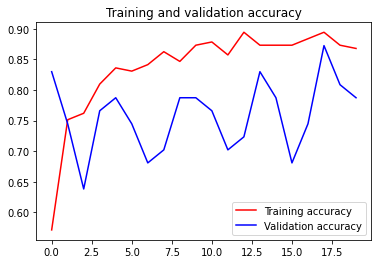

<Figure size 432x288 with 0 Axes>

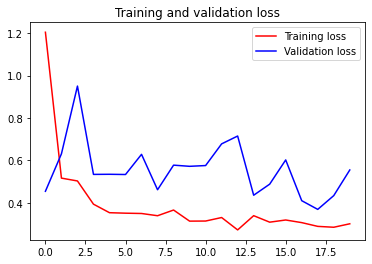

<Figure size 432x288 with 0 Axes>

(None, None)

In [11]:
evaluation_graph(Best_model)

In [12]:
from PIL import Image
def predict_image(imagepath, model):
    predict = load_img(imagepath, target_size = (224, 224))   
    predict_modified = img_to_array(predict)
    predict_modified = predict_modified / 255
    predict_modified = np.expand_dims(predict_modified, axis = 0)
    result = model.predict(predict_modified)
    image = Image.open(imagepath)
    plt.imshow(image)
    if result[0][0] >= 0.5:
        prediction = 'split'
        probability = result[0][0]
        print ("probability = " + str(probability))
        print("Prediction = " + prediction)
    else:
        prediction = 'no_split'
        probability = 1 - result[0][0]
        print ("probability = " + str(probability))
        print("Prediction = " + prediction)

1/1 [==============================] - 1s 826ms/step
probability = 0.6422416865825653
Prediction = no_split


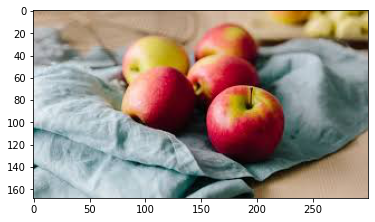

In [13]:
imagepath='/content/gdrive/MyDrive/singles_clean/imagess.jpeg'
predict_image(imagepath, model)

In [14]:
tf.__version__

'2.11.0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')